# Explain GM vs. BGM

In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from graspologic.plot import heatmap
from graspologic.simulations import er_corr
from matplotlib.patches import Rectangle
from matplotlib.patheffects import Normal, Stroke
from pkg.io import OUT_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import merge_axes, multicolor_text, set_theme

FILENAME = "explain"

DISPLAY_FIGS = True

OUT_PATH = OUT_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()

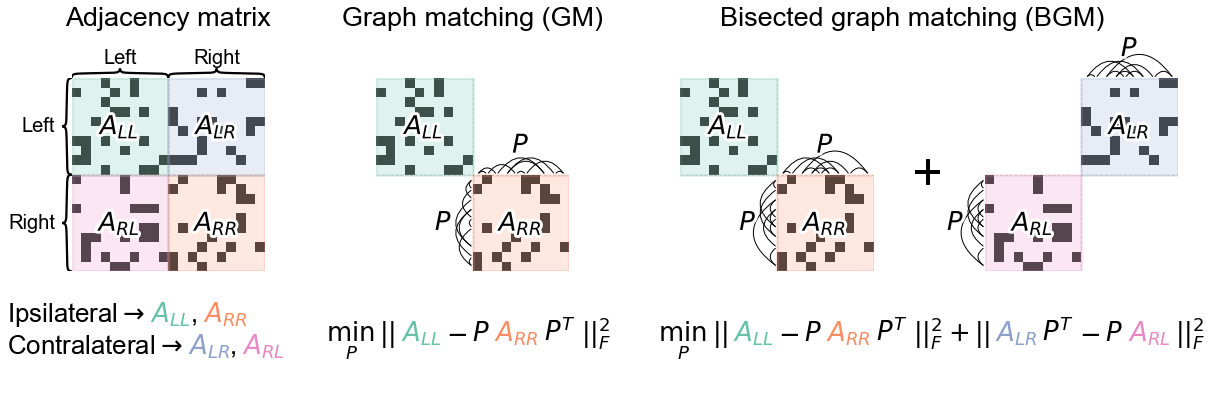

In [2]:
rng = np.random.default_rng(888888)
np.random.seed(888)

fig, axs = plt.subplots(
    2,
    4,
    figsize=(20, 7),
    gridspec_kw=dict(wspace=0.5, height_ratios=[1, 0.2], hspace=0),
)


n = 10
A, B = er_corr(n, 0.3, 0.9, directed=True)
AB, BA = er_corr(n, 0.2, 0.9, directed=True)

# permute one side as appropriate
perm = rng.permutation(n)
undo_perm = np.argsort(perm)
B = B[perm][:, perm]
AB = AB[:, perm]
BA = BA[perm, :]
adj = np.zeros((2 * n, 2 * n))
adj[:n, :n] = A
adj[:n, n:] = AB
adj[n:, :n] = BA
adj[n:, n:] = B

ns = [n, n]
labels = ns[0] * ["Left"] + ns[1] * ["Right"]


subgraph_labels = ["LL", "RR", "LR", "RL"]
colors = sns.color_palette("Set2")
palette = dict(zip(subgraph_labels, colors))


def annotated_heatmap(
    adj, ax, label_ipsi=True, label_contra=True, label_sides=True, title=""
):
    ax = heatmap(
        adj,
        inner_hier_labels=labels,
        cbar=False,
        cmap="Greys",
        center=None,
        ax=ax,
        hier_label_fontsize=20,
        title=title,
        font_scale=1.5,
        vmax=1.2,
    )

    rect_kws = dict(alpha=0.2, zorder=2, linewidth=3)

    if label_ipsi:
        ll = Rectangle((0, 0), width=n, height=n, color=palette["LL"], **rect_kws)
        ax.add_patch(ll)
        rr = Rectangle((n, n), width=n, height=n, color=palette["RR"], **rect_kws)
        ax.add_patch(rr)
        nice_text(n / 2, n / 2, r"$A_{LL}$", ax)
        nice_text(1.5 * n, 1.5 * n, r"$A_{RR}$", ax)
    if label_contra:
        lr = Rectangle((n, 0), width=n, height=n, color=palette["LR"], **rect_kws)
        ax.add_patch(lr)
        rl = Rectangle((0, n), width=n, height=n, color=palette["RL"], **rect_kws)
        ax.add_patch(rl)
        nice_text(n / 2 + n, n / 2, r"$A_{LR}$", ax)
        nice_text(n / 2, n / 2 + n, r"$A_{RL}$", ax)
    if not label_sides:
        fig.axes[-1].set_visible(False)
        fig.axes[-2].set_visible(False)
    lines = ax.get_lines()
    for line_obj in lines:
        line_obj.remove()
    return ax


def nice_text(x, y, s, ax, color="black", fontsize="x-large"):
    text = ax.text(
        x,
        y,
        s,
        color=color,
        fontsize=fontsize,
        transform=ax.transData,
        ha="center",
        va="center",
    )
    text.set_path_effects([Stroke(linewidth=6, foreground="white"), Normal()])


def draw_permutation(permutation, ax, y=0, bump=0, orientation="horizontal"):
    # ax.axhline(0.5, color="black")
    # ax.set_xlim((-0.5, 9.5))

    for target, source in enumerate(permutation):
        if target > source:
            sign = "-"
        else:
            sign = ""
        xy = (target + bump + 0.5, y)
        xytext = (source + bump + 0.5, y)
        if orientation == "vertical":
            xy = xy[::-1]
            xytext = xytext[::-1]
            if sign == "-":
                sign = ""
            else:
                sign = "-"
        ax.annotate(
            "",
            xy=xy,
            xytext=xytext,
            arrowprops=dict(
                arrowstyle="-",
                connectionstyle=f"arc3,rad={sign}0.7",
                facecolor="black",
                linewidth=1,
            ),
        )


def draw_matching(permutation, ax, orientation="horizontal"):
    # ax.axhline(0.5, color="black")
    # ax.set_xlim((-0.5, 9.5))

    for target, source in enumerate(permutation):
        xy = (n, target + 0.5)
        xytext = (source + n + 0.5, n)
        if orientation == "vertical":
            xy = xy[::-1]
            xytext = xytext[::-1]
            sign = "-"
        else:
            sign = ""
        ax.annotate(
            "",
            xy=xy,
            xytext=xytext,
            arrowprops=dict(
                arrowstyle="-",
                connectionstyle=f"arc3,rad={sign}0.4",
                facecolor="black",
                linewidth=1.5,
            ),
        )


ax = axs[0, 0]
annotated_heatmap(adj, ax, title="Adjacency matrix")

adj_no_contra = adj.copy()
adj_no_contra[:n, n:] = 0
adj_no_contra[n:, :n] = 0

permutation = rng.permutation(ns[1])
ax = axs[0, 1]
annotated_heatmap(
    adj_no_contra,
    ax,
    label_ipsi=True,
    label_contra=False,
    label_sides=False,
    title="Graph matching (GM)",
)
draw_permutation(permutation, ax, bump=n, orientation="vertical", y=n)
draw_permutation(permutation, ax, bump=n, orientation="horizontal", y=n)
# draw_matching(permutation, ax, orientation="vertical")
# draw_matching(permutation, ax, orientation="horizontal")
# draw_matching(permutation, ax, bump=n, orientation="horizontal")
nice_text(1.5 * n, 0.7 * n, r"$P$", ax=ax)
nice_text(0.7 * n, 1.5 * n, r"$P$", ax=ax)

# ax.text(
#     1.5 * n,
#     0.6 * n,
#     r"$P$",
#     ha="center",
#     va="center",
#     fontsize="x-large",
# )

permutation = undo_perm
ax = axs[0, 2]
annotated_heatmap(
    adj_no_contra,
    ax,
    label_ipsi=True,
    label_contra=False,
    label_sides=False,
    title="Bisected graph matching (BGM)",
)
draw_permutation(permutation, ax, bump=n, orientation="vertical", y=n)
draw_permutation(permutation, ax, bump=n, orientation="horizontal", y=n)
nice_text(1.5 * n, 0.7 * n, r"$P$", ax=ax)
nice_text(0.7 * n, 1.5 * n, r"$P$", ax=ax)
title_obj = ax.title
title_obj.set_x(1.2)

# title = ax.get_title()/
# title.set_
# draw_matching(permutation, ax, orientation="vertical")
# draw_matching(permutation, ax, orientation="horizontal")

adj_only_contra = adj.copy()
adj_only_contra[:n, :n] = 0
adj_only_contra[n:, n:] = 0

ax = axs[0, 3]
annotated_heatmap(
    adj_only_contra,
    ax,
    label_ipsi=False,
    label_contra=True,
    label_sides=False,
)
draw_permutation(permutation, ax, bump=n, orientation="vertical", y=0)
draw_permutation(permutation, ax, bump=n, orientation="horizontal", y=0)
nice_text(-0.3 * n, 1.5 * n, r"$P$", ax=ax)
nice_text(1.5 * n, -0.3 * n, r"$P$", ax=ax)
nice_text(-0.6 * n, n, r"$+$", ax=ax, fontsize=40)

# annotated_heatmap(
#     adj,
#     ax,
#     label_ipsi=True,
#     label_contra=True,
#     label_sides=False,
#     title="Bisected graph\nmatching (BGM)",
# )
# draw_permutation(permutation, ax, bump=n, orientation="vertical")
# draw_permutation(permutation, ax, bump=n, orientation="horizontal")

ax = axs[1, 0]
ax.axis("off")
multicolor_text(
    -0.27,
    1.1,
    [
        r"Ipsilateral$\rightarrow$",
        r"$A_{LL}$",
        ",",
        r"$A_{RR}$",
    ],
    colors=[
        "black",
        palette["LL"],
        "black",
        palette["RR"],
    ],
    spaces=[True, False, True],
    ax=ax,
    fontsize="x-large",
)
multicolor_text(
    -0.27,
    0.6,
    [
        r"Contralateral$\rightarrow$",
        r"$A_{LR}$",
        ",",
        r"$A_{RL}$",
    ],
    colors=[
        "black",
        palette["LR"],
        "black",
        palette["RL"],
    ],
    spaces=[True, False, True],
    ax=ax,
    fontsize="x-large",
)

ax = axs[1, 1]
ax.axis("off")

multicolor_text(
    -0.2,
    0.8,
    [
        r"$\min_P$",
        r"$\| \|$",
        r"$A_{LL}$",
        r"$-$",
        r"$P$",
        r"$A_{RR}$",
        r"$P^T$",
        r"$\| \|_F^2$",
    ],
    colors=[
        "black",
        "black",
        palette["LL"],
        "black",
        "black",
        palette["RR"],
        "black",
        "black",
    ],
    ax=ax,
    fontsize="x-large",
)


ax = merge_axes(fig, axs, rows=1, cols=(2, 4))
ax.axis("off")
multicolor_text(
    -0.025,
    0.8,
    [
        r"$\min_P$",
        r"$\| \|$",
        r"$A_{LL}$",
        r"$-$",
        r"$P$",
        r"$A_{RR}$",
        r"$P^T$",
        r"$\| \|_F^2$",
        r"$+$",
        r"$\| \|$",
        r"$A_{LR}$",
        r"$P^T$",
        r"$-$",
        r"$P$",
        r"$A_{RL}$",
        r"$\| \|_F^2$",
    ],
    colors=[
        "black",
        "black",
        palette["LL"],
        "black",
        "black",
        palette["RR"],
        "black",
        "black",
        "black",
        "black",
        palette["LR"],
        "black",
        "black",
        "black",
        palette["RL"],
        "black",
    ],
    ax=ax,
    fontsize="x-large",
)

gluefig("explain", fig)

## End

In [3]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:06.327310
Completed at 2022-05-19 11:20:07.170147
